# Trabajo Práctico N° 2
## Objetivo:

Para cada dispositivo presentado por Jampp, determinar el tiempo que transcurrirá hasta que el mismo aparezca nuevamente en una subasta, y el tiempo hasta que el usuario del mismo decida instalar una nueva aplicación.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import datetime as dt
import xgboost as xgb

## Primero veo los dispositivos del target

In [2]:
target = pd.read_csv('data/target_competencia_ids.csv')

In [3]:
target.head()

,ref_hash,obj
0,1000169251625791246_sc,0
1,1000169251625791246_st,0
2,1000395625957344683_sc,0
3,1000395625957344683_st,0
4,1003027494996471685_sc,0


In [4]:
target.size

16148

Tomo los ref_hash

In [5]:
target['ref_hash'] = target['ref_hash'].transform(lambda x: str(x)[:-3])

In [6]:
target['ref_hash'] = target['ref_hash'].astype(np.int64)
target.head()

,ref_hash,obj
0,1000169251625791246,0
1,1000169251625791246,0
2,1000395625957344683,0
3,1000395625957344683,0
4,1003027494996471685,0


In [7]:
target.drop_duplicates(subset = 'ref_hash', inplace = True)

In [8]:
target.count()

ref_hash    4037
obj         4037
dtype: int64

## Calculo cuanto tiempo tarda un dispositivo en aparecer en una subasta contando desde el inicio de la ventana que quiero predecir

La idea es determinar el tiempo que transcurrió entre cada aparición de un dispositivo en una subasta, para luego tomar el tiempo mínimo de aparición de un dispositivo en una subasta y de acuerdo a eso predecir utilizando los features de la ventana anterior.

In [9]:
auct_predict = pd.read_csv('data/auctions_ventana7.csv', dtype = { "ref_type_id": np.int8, "source_id": np.int8})

In [10]:
auct_predict['date'] = pd.to_datetime(auct_predict['date'])
auct_predict['date_inicial'] = dt.datetime(2019,4, 24)
auct_predict['timeToAuction'] = (auct_predict['date'] - auct_predict['date_inicial'])/np.timedelta64(1,'s')

In [11]:
auct_predict['timeToAuction'] = auct_predict['timeToAuction'].transform(lambda x: (72 * 60 * 60) if (x < 0) else x)
auct_predict.head()

,date,device_id,ref_type_id,source_id,date_inicial,timeToAuction
0,2019-04-26 23:52:29.135354,1384623003476985820,1,7,2019-04-24,258749.135354
1,2019-04-26 23:52:39.367477,3714738743084512188,1,7,2019-04-24,258759.367477
2,2019-04-26 23:52:54.714361,5697386557321863111,1,7,2019-04-24,258774.714361
3,2019-04-26 23:53:13.729835,5583037045722622336,1,7,2019-04-24,258793.729835
4,2019-04-26 23:53:48.577115,6383034009915294411,1,7,2019-04-24,258828.577115


Tomo el tiempo mínimo, en SEGUNDOS, que tardó cada dispositivo en aparecer en una subasta

In [12]:
auction_time = auct_predict.groupby('device_id').agg({'timeToAuction': 'min'}).reset_index()
auction_time.columns = ['ref_hash', 'predict_value']
auction_time.head()

,ref_hash,predict_value
0,69039685746313,126258.597103
1,345999128501141,250362.048531
2,360710529886978,46687.256609
3,365882020742330,96627.763854
4,416301579449694,12569.446617


In [13]:
auction_time = target[['ref_hash']].merge(auction_time, on = 'ref_hash', how = 'left')
auction_time['predict_value'] = auction_time['predict_value'].fillna((72 * 60 * 60)) # Los que no aparecieron 

In [14]:
auction_time.merge(target[['ref_hash']]).nunique()

ref_hash         4037
predict_value    3352
dtype: int64

# Analizo los datos de la ventana anterior

In [15]:
auct = pd.read_csv('data/auctions_ventana6.csv', dtype = { "ref_type_id": np.int8, "source_id": np.int8})

In [16]:
auct.dtypes

date           object
device_id       int64
ref_type_id      int8
source_id        int8
dtype: object

In [17]:
auct['date'] = pd.to_datetime(auct['date'])

In [18]:
auct.head()

,date,device_id,ref_type_id,source_id
0,2019-04-23 18:58:00.842116,2564673204772915246,1,0
1,2019-04-23 18:58:01.530771,4441121667607578179,7,0
2,2019-04-23 18:58:01.767562,7721769811471055264,1,0
3,2019-04-23 18:58:02.363468,6416039086842158968,1,0
4,2019-04-23 18:58:02.397559,1258642015983312729,1,0


## Veo cuantas veces aparece cada dispositivo en una subasta

Inicio sencillamente contando la cantidad de subastas en las que participó cada dispositivo, y lo agrego como un nuevo feature

In [19]:
auction_count = auct.groupby('device_id').agg({'date': 'count'}).reset_index()
auction_count.columns = ['ref_hash', 'auctions_count']

In [20]:
auction_count.head()

,ref_hash,auctions_count
0,40621409780134,1
1,69039685746313,4
2,168103949904656,1
3,186034136943920,13
4,345999128501141,23


Creo un único set de datos con los primeros features creados usando los ids de los dispositivos de la ventana 2

In [21]:
data = auction_time.merge(auction_count, on = 'ref_hash', how = 'left')

In [22]:
data.head()

,ref_hash,predict_value,auctions_count
0,1000169251625791246,76114.647428,7.0
1,1000395625957344683,8034.974209,16.0
2,1003027494996471685,12171.691046,168.0
3,1006670001679961544,64857.606340,1.0
4,1007573308966476713,18726.239096,7.0


In [23]:
data['auctions_count'] = data['auctions_count'].fillna(0)

In [24]:
data.nunique()

ref_hash          4037
predict_value     3352
auctions_count     364
dtype: int64

## Pruebo con Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

y = data['predict_value']
X = data.drop(['ref_hash', 'predict_value'], axis=1)

RFR = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
RFR.fit(X, y)  
RFR.feature_importances_

array([1.])

In [26]:
predictions = cross_val_predict(RFR, X, y, cv=10)
predictions

array([ 69976.67331487,  49914.82106822,  46316.29762504, ...,
        49995.95463705, 238381.20487221,  48237.13538859])

In [27]:
scores = cross_val_score(RFR, X, y, cv=5, scoring='neg_mean_squared_error')

## Calculo el RMSE

In [28]:
# convierto los valores a MSE scores
mse_scores = -scores
# paso de MSE a RMSE
rmse_scores = np.sqrt(mse_scores)

In [29]:
rmse_scores.mean()

60578.116608137745

## Pruebo con xgboost

In [30]:
y = data['predict_value']
X = data.drop(['ref_hash', 'predict_value'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

mse_scores = -scores
# paso de MSE a RMSE
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:23:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:23:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


59090.82098778694

## Veo la cantidad de veces que aparece cada dispositivo segun el source_id

Ahora me interesa ver la cantidad de veces que un dispositivo participó en una subasta desde cada tipo de fuente desde donde se produce la subasta. De esta manera los source_id más populares tomaran un valor mayor, luego tomo la desviación estándar de la cantidad para cada device_id

In [31]:
auct['apariciones'] = 1

In [32]:
auction_by_sourceID = auct.groupby(['device_id', 'source_id']).agg({'apariciones':'sum'}).unstack(1).fillna(0).reset_index()
auction_by_sourceID.columns = auction_by_sourceID.columns.droplevel(0)
auction_by_sourceID.columns = ['ref_hash', 'source_id0', 'source_id1', 'source_id2', 'source_id3', 'source_id4', 'source_id5', 'source_id6', 'source_id7', 'source_id8', 'source_id9']
auction_by_sourceID.head()

,ref_hash,source_id0,source_id1,source_id2,source_id3,source_id4,source_id5,source_id6,source_id7,source_id8,source_id9
0,40621409780134,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,69039685746313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
2,168103949904656,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,186034136943920,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,345999128501141,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
auction_by_sourceID['auctions_by_srcID'] = auction_by_sourceID.iloc[:,1:].std(axis = 1)
auction_by_sourceID.head()

,ref_hash,source_id0,source_id1,source_id2,source_id3,source_id4,source_id5,source_id6,source_id7,source_id8,source_id9,auctions_by_srcID
0,40621409780134,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316228
1,69039685746313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.264911
2,168103949904656,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316228
3,186034136943920,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.110961
4,345999128501141,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.273239


Agrego el nuevo feature a los datos

In [34]:
data1 = auction_time.merge(auction_by_sourceID, on = 'ref_hash', how = 'left')#data.merge(auction_by_sourceID[['ref_hash', 'auctions_by_srcID']], on = 'ref_hash')


In [35]:
data1.head()

,ref_hash,predict_value,source_id0,source_id1,source_id2,source_id3,source_id4,source_id5,source_id6,source_id7,source_id8,source_id9,auctions_by_srcID
0,1000169251625791246,76114.647428,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.213594
1,1000395625957344683,8034.974209,0.0,11.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,3.470511
2,1003027494996471685,12171.691046,102.0,3.0,0.0,23.0,2.0,0.0,36.0,0.0,2.0,0.0,32.358410
3,1006670001679961544,64857.606340,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316228
4,1007573308966476713,18726.239096,0.0,4.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.337494


In [36]:
data1 = data1.fillna(0)

In [37]:
data1.count()

ref_hash             4037
predict_value        4037
source_id0           4037
source_id1           4037
source_id2           4037
source_id3           4037
source_id4           4037
source_id5           4037
source_id6           4037
source_id7           4037
source_id8           4037
source_id9           4037
auctions_by_srcID    4037
dtype: int64

Vuelvo a probar el modelo con el nuevo feature

In [38]:
y = data1['predict_value']
X = data1.drop(['ref_hash', 'predict_value'], axis=1)

RFR = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
RFR.fit(X, y)  

RFR.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [39]:
cross_val_predict(RFR, X, y, cv=10)

array([ 54302.46516123,  51515.42077254,  46283.48433966, ...,
        56860.94544132, 238381.20487221,  47266.23207116])

In [40]:
scores = cross_val_score(RFR, X, y, cv=10, scoring='neg_mean_squared_error')

In [41]:
# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

60557.2203420765

Pruebo xgboost

In [42]:
y = data1['predict_value']
X = data1.drop(['ref_hash', 'predict_value'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

mse_scores = -scores
# paso de MSE a RMSE
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:24:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


58897.072885290676

El nuevo feature logró bajar el score promedio de RMSE, así que lo mantenemos en el dataset de features.

## Veo la cantidad de veces que aparece cada dispositivo en una subasta según el ref_type

In [43]:
auct['ref_type_id'].value_counts()

1    13578285
7     2403532
Name: ref_type_id, dtype: int64

In [44]:
dfApRef = auct.groupby(['device_id', 'ref_type_id']).agg({'apariciones':'sum'}).unstack(1).fillna(0).reset_index()
dfApRef.columns = dfApRef.columns.droplevel(0)
dfApRef['median_count_ref_type'] = dfApRef.median(axis = 1)
dfApRef.head()

ref_type_id,,1,7,median_count_ref_type
0,40621409780134,1.0,0.0,1.0
1,69039685746313,4.0,0.0,4.0
2,168103949904656,1.0,0.0,1.0
3,186034136943920,13.0,0.0,13.0
4,345999128501141,23.0,0.0,23.0


Me interesa ver si cada usuario sólo tiene apariciones para el mismo ref_type, lo chequeo para ver si me servirá o no el feature

In [45]:
dfApRef.columns = ['ref_hash', 'auctions_ref_type1', 'auctions_ref_type7', 'median_count_ref_type']
dfApRef.head()

,ref_hash,auctions_ref_type1,auctions_ref_type7,median_count_ref_type
0,40621409780134,1.0,0.0,1.0
1,69039685746313,4.0,0.0,4.0
2,168103949904656,1.0,0.0,1.0
3,186034136943920,13.0,0.0,13.0
4,345999128501141,23.0,0.0,23.0


In [46]:
dfApRef['aparece_en_distinto_ref_type'] = ((dfApRef['auctions_ref_type1'] > 0) & (dfApRef['auctions_ref_type7'] > 0))

In [47]:
dfApRef.head()

,ref_hash,auctions_ref_type1,auctions_ref_type7,median_count_ref_type,aparece_en_distinto_ref_type
0,40621409780134,1.0,0.0,1.0,False
1,69039685746313,4.0,0.0,4.0,False
2,168103949904656,1.0,0.0,1.0,False
3,186034136943920,13.0,0.0,13.0,False
4,345999128501141,23.0,0.0,23.0,False


In [48]:
dfApRef['aparece_en_distinto_ref_type'].value_counts()

False    322175
True        228
Name: aparece_en_distinto_ref_type, dtype: int64

Como hay valores para ref_types distintos puedo probar agregar este feature y ver que sucede

In [49]:
data2 = data1.merge(dfApRef[['ref_hash', 'median_count_ref_type']], on = 'ref_hash', how = 'left')
data2.head()

,ref_hash,predict_value,source_id0,source_id1,source_id2,source_id3,source_id4,source_id5,source_id6,source_id7,source_id8,source_id9,auctions_by_srcID,median_count_ref_type
0,1000169251625791246,76114.647428,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.213594,7.0
1,1000395625957344683,8034.974209,0.0,11.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,3.470511,16.0
2,1003027494996471685,12171.691046,102.0,3.0,0.0,23.0,2.0,0.0,36.0,0.0,2.0,0.0,32.358410,168.0
3,1006670001679961544,64857.606340,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316228,1.0
4,1007573308966476713,18726.239096,0.0,4.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.337494,7.0


In [50]:
data2['median_count_ref_type'] = data2['median_count_ref_type'].fillna(0)
data2.count()

ref_hash                 4037
predict_value            4037
source_id0               4037
source_id1               4037
source_id2               4037
source_id3               4037
source_id4               4037
source_id5               4037
source_id6               4037
source_id7               4037
source_id8               4037
source_id9               4037
auctions_by_srcID        4037
median_count_ref_type    4037
dtype: int64

In [51]:
y = data2['predict_value']
X = data2.drop(['ref_hash', 'predict_value'], axis=1)

RFR = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
RFR.fit(X, y)  

RFR.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.50083432, 0.49916568])

In [52]:
cross_val_predict(RFR, X, y, cv=10)

array([ 67012.78148924,  50442.44250719,  46278.44673352, ...,
        52409.20920945, 238381.20487221,  47917.38868811])

In [53]:
scores = cross_val_score(RFR, X, y, cv=5, scoring='neg_mean_squared_error')

In [54]:
# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

60560.26403809084

## XGBoost

In [55]:
y = data2['predict_value']
X = data2.drop(['ref_hash', 'predict_value'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

mse_scores = -scores
# paso de MSE a RMSE
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:24:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


58914.754836330496

## Cantidad de apariciones de un dispositivo en las subastas por día

Calculo la cantidad de apariciones para cada dispositivo en las subastas por día, luego tomo la mediana para las apariciones.

In [56]:
auct['fecha'] = auct['date'].dt.date

In [57]:
dfApDay = auct.groupby(['device_id', 'fecha']).agg({'apariciones':'sum'}).unstack(1).fillna(0).reset_index()
dfApDay.columns = dfApDay.columns.droplevel(0)
dfApDay.columns = ['ref_hash', '2019-04-23', '2019-04-24', '2019-04-25']
dfApDay['auctions_by_day'] = dfApDay.median(axis = 1)

In [58]:
dfApDay.head()

,ref_hash,2019-04-23,2019-04-24,2019-04-25,auctions_by_day
0,40621409780134,1.0,0.0,0.0,0.5
1,69039685746313,0.0,0.0,4.0,2.0
2,168103949904656,1.0,0.0,0.0,0.5
3,186034136943920,13.0,0.0,0.0,6.5
4,345999128501141,23.0,0.0,0.0,11.5


Agrego el nuevo feature

In [59]:
data3 = data1.merge(dfApDay[['ref_hash', 'auctions_by_day']], on = 'ref_hash', how = 'left')
data3.head()

,ref_hash,predict_value,source_id0,source_id1,source_id2,source_id3,source_id4,source_id5,source_id6,source_id7,source_id8,source_id9,auctions_by_srcID,auctions_by_day
0,1000169251625791246,76114.647428,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.213594,2.5
1,1000395625957344683,8034.974209,0.0,11.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,3.470511,7.0
2,1003027494996471685,12171.691046,102.0,3.0,0.0,23.0,2.0,0.0,36.0,0.0,2.0,0.0,32.358410,84.0
3,1006670001679961544,64857.606340,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316228,0.5
4,1007573308966476713,18726.239096,0.0,4.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.337494,3.0


In [60]:
data3['auctions_by_day'] = data3['auctions_by_day'].fillna(0)
data3.nunique()

ref_hash             4037
predict_value        3352
source_id0            188
source_id1            271
source_id2             23
source_id3            132
source_id4             30
source_id5             37
source_id6             57
source_id7             39
source_id8             34
source_id9              3
auctions_by_srcID    1330
auctions_by_day       347
dtype: int64

Ahora puebo el modelo

In [61]:
y = data3['predict_value']
X = data3.drop(['ref_hash', 'predict_value'], axis=1)

RFR = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
RFR.fit(X, y)  

RFR.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.58373346, 0.41626654])

In [62]:
cross_val_predict(RFR, X, y, cv=10)

array([ 54923.89656299,  51514.69436878,  46282.7579359 , ...,
        56782.37113956, 238381.20487221,  47187.6577694 ])

In [63]:
scores = cross_val_score(RFR, X, y, cv=5, scoring='neg_mean_squared_error')


In [64]:
# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

60609.78915114708

## Pruebo con Gradient Boosting Regressor

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor(random_state=23, n_estimators=50, min_samples_split=50)
scores = cross_val_score(GBR , X, y, scoring = "neg_mean_squared_error", cv=5)


In [66]:
# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

58671.19943156609

## Ahora pruebo con XGBoost 

In [67]:
XGB = xgb.XGBRegressor()

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [68]:
# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

58594.41403452668

El score con xgboost bajó, así que voy a mantener este feature

## Agrego como feature el tiempo minimo de aparición de un dispositivo durante la ventana anterior a la ventana en la que voy a predecir.

La idea de este feature es estudiar el comportamiento de los dispositivos, sus tiempos de aparición y calcular el mínimo tiempo entre ellos para tener un estimativo del tiempo a predecir.


In [69]:
apariciones_auctions = auct[['date', 'device_id']]
apariciones_auctions.head()

,date,device_id
0,2019-04-23 18:58:00.842116,2564673204772915246
1,2019-04-23 18:58:01.530771,4441121667607578179
2,2019-04-23 18:58:01.767562,7721769811471055264
3,2019-04-23 18:58:02.363468,6416039086842158968
4,2019-04-23 18:58:02.397559,1258642015983312729


In [70]:
apariciones_auctions['date'] = pd.to_datetime(apariciones_auctions['date'])
apariciones_auctions['date_inicial'] = dt.datetime(2019,4, 23)
apariciones_auctions['timeToAuction'] = (apariciones_auctions['date'] - apariciones_auctions['date_inicial'])/np.timedelta64(1,'s')
apariciones_auctions.head()

/home/sol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/sol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

,date,device_id,date_inicial,timeToAuction
0,2019-04-23 18:58:00.842116,2564673204772915246,2019-04-23,68280.842116
1,2019-04-23 18:58:01.530771,4441121667607578179,2019-04-23,68281.530771
2,2019-04-23 18:58:01.767562,7721769811471055264,2019-04-23,68281.767562
3,2019-04-23 18:58:02.363468,6416039086842158968,2019-04-23,68282.363468
4,2019-04-23 18:58:02.397559,1258642015983312729,2019-04-23,68282.397559


In [71]:
apariciones_auctions = apariciones_auctions.groupby('device_id').agg({'timeToAuction': ['min', 'max']}).reset_index()
apariciones_auctions.columns = apariciones_auctions.columns.droplevel(0)
apariciones_auctions.columns = ['ref_hash', 'timeToAuction_min', 'timeToAuction_max']
apariciones_auctions.head()

,ref_hash,timeToAuction_min,timeToAuction_max
0,40621409780134,54057.222979,54057.222979
1,69039685746313,212658.597103,213104.792132
2,168103949904656,244.526198,244.526198
3,186034136943920,3832.719160,49809.087219
4,345999128501141,75989.933696,83565.879898


Agrego el nuevo feature 

In [72]:
data4 = data3.merge(apariciones_auctions[['ref_hash', 'timeToAuction_min']], on = 'ref_hash', how = 'left')

In [73]:
data4.head()

,ref_hash,predict_value,source_id0,source_id1,source_id2,source_id3,source_id4,source_id5,source_id6,source_id7,source_id8,source_id9,auctions_by_srcID,auctions_by_day,timeToAuction_min
0,1000169251625791246,76114.647428,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.213594,2.5,46581.029283
1,1000395625957344683,8034.974209,0.0,11.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,3.470511,7.0,2467.488253
2,1003027494996471685,12171.691046,102.0,3.0,0.0,23.0,2.0,0.0,36.0,0.0,2.0,0.0,32.358410,84.0,98571.691046
3,1006670001679961544,64857.606340,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316228,0.5,151257.606340
4,1007573308966476713,18726.239096,0.0,4.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.337494,3.0,32222.420264


In [74]:
data4['timeToAuction_min'] = data4['timeToAuction_min'].fillna(72 * 60 * 60)
#data4['timeToAuction_max'] = data4['timeToAuction_max'].fillna(72 * 60 * 60)
data4.count()

ref_hash             4037
predict_value        4037
source_id0           4037
source_id1           4037
source_id2           4037
source_id3           4037
source_id4           4037
source_id5           4037
source_id6           4037
source_id7           4037
source_id8           4037
source_id9           4037
auctions_by_srcID    4037
auctions_by_day      4037
timeToAuction_min    4037
dtype: int64

In [75]:
data4.nunique()

ref_hash             4037
predict_value        3352
source_id0            188
source_id1            271
source_id2             23
source_id3            132
source_id4             30
source_id5             37
source_id6             57
source_id7             39
source_id8             34
source_id9              3
auctions_by_srcID    1330
auctions_by_day       347
timeToAuction_min    3134
dtype: int64

## Pruebo con XGBoost

In [76]:
y = data4['predict_value']
X = data4.drop(['ref_hash', 'predict_value'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:24:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [77]:
# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

47553.36975291654

Este feature mejoró muchísimo el score, lo mantengo

## Agrego Features sobre los eventos

In [78]:
evts = pd.read_csv("data/events_ventana6.csv", dtype = {"event_id": np.int16, "application_id": np.int16, 'device_countrycode': 'category', 'device_os_version': 'category', 'device_brand': 'category', 'device_model': 'category', 'device_city': 'category', 'session_user_agent': 'category', 'trans_id': 'category', 'user_agent': 'category', 'carrier' : 'category', 'kind': 'category', 'device_os': 'category', 'connection_type': 'category', 'ip_address': 'category', 'device_language': 'category'})

In [79]:
evts.head()

,date,event_id,ref_type,ref_hash,application_id,attributed,device_countrycode,device_os_version,device_brand,device_model,...,trans_id,user_agent,event_uuid,carrier,kind,device_os,wifi,connection_type,ip_address,device_language
0,2019-04-23 19:39:41.432,1,1891515180541284343,1194609495716092219,210,False,6287817205707153877,NaN,NaN,NaN,...,NaN,NaN,616fa46f-022d-42ee-bac0-b6f198c990fb,NaN,4.017674184041173e+18,NaN,False,NaN,3439795381561635433,NaN
1,2019-04-23 19:39:41.452,3,1891515180541284343,3010904108806702053,210,False,6287817205707153877,NaN,NaN,NaN,...,NaN,NaN,00d319e8-ab25-4273-bc4e-94e640d4e672,NaN,4.171877563864664e+18,NaN,False,NaN,1571230486156913384,NaN
2,2019-04-23 19:39:47.663,1,1891515180541284343,533823888497265387,210,False,6287817205707153877,NaN,NaN,NaN,...,NaN,NaN,9e91953b-6ec9-4910-a8ec-2e638a121e10,NaN,4.017674184041173e+18,NaN,False,NaN,733507205645556757,NaN
3,2019-04-23 19:39:29.651,0,1891515180541284343,799618390823692724,210,False,6287817205707153877,NaN,NaN,6.337249180536332e+18,...,NaN,6.786633061620543e+18,0b071bf2-ec24-4d88-9c8d-717ad6f24716,NaN,5.882882097123621e+18,NaN,False,NaN,4612010035990846396,3.3013777759777e+18
4,2019-04-23 19:39:29.333,0,1891515180541284343,3683187645927407708,210,False,6287817205707153877,NaN,NaN,6.927805691049656e+18,...,NaN,8.086662473506366e+18,40bfda98-f6a9-4106-9fa4-e714482b0a50,NaN,5.882882097123621e+18,NaN,False,NaN,3737747398007847364,3.3013777759777e+18


## Aplicaciones populares

Agrego Features tomando en cuenta cuales la popularidad de las applicaciones. La idea es generar un feature que asigne un número a cada dispositivo de acuerdo al id de la applicación.

In [80]:
apps_populares = evts[['application_id', 'ref_hash']].groupby('application_id').count().reset_index()
apps_populares.columns = ['application_id', 'popularidad_app']
apps_populares.head()

,application_id,popularidad_app
0,1,9
1,2,114
2,3,1545
3,5,34
4,6,26


In [81]:
apps_populares = evts[['ref_hash', 'application_id']].merge(apps_populares, on = 'application_id')
apps_populares.head()

,ref_hash,application_id,popularidad_app
0,1194609495716092219,210,665827
1,3010904108806702053,210,665827
2,533823888497265387,210,665827
3,799618390823692724,210,665827
4,3683187645927407708,210,665827


In [82]:
apps_counts = evts[['date', 'ref_hash', 'application_id']].groupby(['ref_hash', 'application_id']).count().reset_index()
apps_counts.head()

,ref_hash,application_id,date
0,40621409780134,77,3
1,69039685746313,226,6
2,90072729247980,210,3
3,161514654074162,65,5
4,161514654074162,121,4


In [83]:
# Le asigno a cada dispositivo la popularidad de la applicación en la cual generó más eventos
apps_pops_events = apps_counts.groupby(['ref_hash']).agg({'date': 'max'}).reset_index()
apps_pops_events.columns = ['ref_hash', 'popularidad_apps_events']
apps_pops_events.head()

,ref_hash,popularidad_apps_events
0,40621409780134,3
1,69039685746313,6
2,90072729247980,3
3,161514654074162,5
4,168103949904656,3


Agrego el nuevo feature a los datos

In [84]:
data5 = data4.merge(apps_pops_events, on = 'ref_hash', how = 'left')
data.head()

,ref_hash,predict_value,auctions_count
0,1000169251625791246,76114.647428,7.0
1,1000395625957344683,8034.974209,16.0
2,1003027494996471685,12171.691046,168.0
3,1006670001679961544,64857.606340,1.0
4,1007573308966476713,18726.239096,7.0


In [85]:
data5['popularidad_apps_events'] = data5['popularidad_apps_events'].fillna(0)
data5.count()

ref_hash                   4037
predict_value              4037
source_id0                 4037
source_id1                 4037
source_id2                 4037
source_id3                 4037
source_id4                 4037
source_id5                 4037
source_id6                 4037
source_id7                 4037
source_id8                 4037
source_id9                 4037
auctions_by_srcID          4037
auctions_by_day            4037
timeToAuction_min          4037
popularidad_apps_events    4037
dtype: int64

In [86]:
data5.nunique()

ref_hash                   4037
predict_value              3352
source_id0                  188
source_id1                  271
source_id2                   23
source_id3                  132
source_id4                   30
source_id5                   37
source_id6                   57
source_id7                   39
source_id8                   34
source_id9                    3
auctions_by_srcID          1330
auctions_by_day             347
timeToAuction_min          3134
popularidad_apps_events     119
dtype: int64

## Pruebo el feature con XGBoost

In [87]:
y = data5['predict_value']
X = data5.drop(['ref_hash', 'predict_value'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:24:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


47438.209011233725

con este feature el score bajó un poco así que lo mantengo

## Agrego un feature tomando en cuenta la cantidad de eventos en los que participó cada dispositivo

In [88]:
count_events = evts.groupby('ref_hash').agg({'date': 'count'}).reset_index()
count_events.columns = ['ref_hash', 'count_events']
count_events.head()

,ref_hash,count_events
0,40621409780134,3
1,69039685746313,6
2,90072729247980,3
3,161514654074162,9
4,168103949904656,3


Agrego el nuevo feature y veo qué sucede con el score

In [89]:
data6 = data5.merge(count_events, on = 'ref_hash', how = 'left')
data6['count_events'] = data6['count_events'].fillna(0)

In [90]:
data6.count()

ref_hash                   4037
predict_value              4037
source_id0                 4037
source_id1                 4037
source_id2                 4037
source_id3                 4037
source_id4                 4037
source_id5                 4037
source_id6                 4037
source_id7                 4037
source_id8                 4037
source_id9                 4037
auctions_by_srcID          4037
auctions_by_day            4037
timeToAuction_min          4037
popularidad_apps_events    4037
count_events               4037
dtype: int64

In [91]:
data6.nunique()

ref_hash                   4037
predict_value              3352
source_id0                  188
source_id1                  271
source_id2                   23
source_id3                  132
source_id4                   30
source_id5                   37
source_id6                   57
source_id7                   39
source_id8                   34
source_id9                    3
auctions_by_srcID          1330
auctions_by_day             347
timeToAuction_min          3134
popularidad_apps_events     119
count_events                121
dtype: int64

## Vuelvo a probar el modelo con XGBoost

In [92]:
y = data6['predict_value']
X = data6.drop(['ref_hash', 'predict_value'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:24:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


47452.908396175124

se puede ver que este feature empeoró el score, así que lo descartamos

## Agrego el tiempo que tarda cada dispositivo en generar el primer evento

In [93]:
events_time = evts[['date', 'ref_hash']]
events_time['date'] = pd.to_datetime(evts['date'])
events_time['date_inicial'] = dt.datetime(2019,4, 23)
events_time['timeToEvent'] = (events_time['date'] - events_time['date_inicial'])/np.timedelta64(1,'s')
events_time.head()

/home/sol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

,date,ref_hash,date_inicial,timeToEvent
0,2019-04-23 19:39:41.432,1194609495716092219,2019-04-23,70781.432
1,2019-04-23 19:39:41.452,3010904108806702053,2019-04-23,70781.452
2,2019-04-23 19:39:47.663,533823888497265387,2019-04-23,70787.663
3,2019-04-23 19:39:29.651,799618390823692724,2019-04-23,70769.651
4,2019-04-23 19:39:29.333,3683187645927407708,2019-04-23,70769.333


In [94]:
events_time = events_time.groupby('ref_hash').agg({'timeToEvent': ['min', 'max']}).reset_index()
events_time.columns = events_time.columns.droplevel(0)
events_time.columns = ['ref_hash', 'timeToEvent_min', 'timeToEvent_max']
events_time.head()

,ref_hash,timeToEvent_min,timeToEvent_max
0,40621409780134,54080.504,54120.589
1,69039685746313,63136.586,245237.732
2,90072729247980,153053.967,153076.624
3,161514654074162,65879.801,240633.535
4,168103949904656,195695.011,195749.096


Agrego el nuevo feature

In [95]:
data7 = data5.merge(events_time[['ref_hash', 'timeToEvent_min']], on = 'ref_hash', how = 'left')
data7.head()

,ref_hash,predict_value,source_id0,source_id1,source_id2,source_id3,source_id4,source_id5,source_id6,source_id7,source_id8,source_id9,auctions_by_srcID,auctions_by_day,timeToAuction_min,popularidad_apps_events,timeToEvent_min
0,1000169251625791246,76114.647428,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.213594,2.5,46581.029283,3.0,6976.388
1,1000395625957344683,8034.974209,0.0,11.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,3.470511,7.0,2467.488253,0.0,NaN
2,1003027494996471685,12171.691046,102.0,3.0,0.0,23.0,2.0,0.0,36.0,0.0,2.0,0.0,32.358410,84.0,98571.691046,14.0,3666.737
3,1006670001679961544,64857.606340,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316228,0.5,151257.606340,0.0,NaN
4,1007573308966476713,18726.239096,0.0,4.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.337494,3.0,32222.420264,0.0,NaN


In [96]:
data7['timeToEvent_min'] = data7['timeToEvent_min'].fillna(72 * 60 * 60)
#data7['timeToEvent_max'] = data7['timeToEvent_max'].fillna(72 * 60 * 60)
data7.count()

ref_hash                   4037
predict_value              4037
source_id0                 4037
source_id1                 4037
source_id2                 4037
source_id3                 4037
source_id4                 4037
source_id5                 4037
source_id6                 4037
source_id7                 4037
source_id8                 4037
source_id9                 4037
auctions_by_srcID          4037
auctions_by_day            4037
timeToAuction_min          4037
popularidad_apps_events    4037
timeToEvent_min            4037
dtype: int64

In [97]:
data7.nunique()

ref_hash                   4037
predict_value              3352
source_id0                  188
source_id1                  271
source_id2                   23
source_id3                  132
source_id4                   30
source_id5                   37
source_id6                   57
source_id7                   39
source_id8                   34
source_id9                    3
auctions_by_srcID          1330
auctions_by_day             347
timeToAuction_min          3134
popularidad_apps_events     119
timeToEvent_min            1848
dtype: int64

Pruebo el modelo con el nuevo feature

In [98]:
y = data7['predict_value']
X = data7.drop(['ref_hash', 'predict_value'], axis=1)

XGB = xgb.XGBRegressor(learning_rate =0.075, n_estimators=95, max_depth=4, min_child_weight=6, 
                         gamma=0.3, subsample=0.8, colsample_bytree=0.8,
                         scale_pos_weight=0.8, seed = 15)
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:24:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:24:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


47454.898463615355

# Busco los mejores hiperparámetros para xgboost utilizando gridSearch

In [99]:
XGB = xgb.XGBRegressor()

In [100]:
parameters_for_testing = {'max_depth': [2,3],
    'learning_rate': [0.1,0.2],
    'n_estimators': [95, 100],
    'n_jobs': [1,2],
    'gamma': [0,0.2],
    'subsample': [0.9,1],
    'reg_alpha': [0,0.1,0.2],
    'reg_lambda': [0.9, 1,],
    'seed': [0,15]}

                
xgb_model = xgb.XGBRegressor()

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(X,y)

Fitting 3 folds for each of 768 candidates, totalling 2304 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    9.7s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    9.9s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   10.5s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   10.9s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   11.7s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   12.4s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   13.2s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   13.9s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:   15.4s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:   18.3s
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:   22.6s
[Para

[11:31:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_sta...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid=False, n_jobs=6,
             param_grid={'gamma': [0, 0.2], 'learning_rate': [0.1, 0.2],
                         'max_depth': [2, 3], 'n_estimators': [95, 100],
                         'n_jobs': [1, 2

In [101]:
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)


best params
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 1, 'reg_alpha': 0.1, 'reg_lambda': 1, 'seed': 15, 'subsample': 0.9}
best score
-2268551761.276816


In [102]:
score = -gsearch1.best_score_
rmse = np.sqrt(score)
rmse

47629.31619577186

# Pruebo los features anteriores para predecir los tiempos de conversiones

In [103]:
inst = pd.read_csv('data/installs_ventana7.csv', dtype = {'application_id': np.int16, 'ref_type': 'category', 'click_hash': 'category', 'device_country_code': 'category', 'device_brand': 'category', 'device_model': 'category', 'kind': 'category', 'device_language': 'category'})

## Installs

Tomo los tiempos de la primera conversión de cada dispositivo dentro de la ventana 2 para entrenar el algoritmo luego

In [104]:
inst['created'] = pd.to_datetime(inst['created'])
inst.head()

,created,application_id,ref_type,ref_hash,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,session_user_agent,user_agent,event_uuid,kind,wifi,trans_id,ip_address,device_language
0,2019-04-24 06:23:29.495,1,1494519392962156891,4716708407362582887,NaN,False,True,6287817205707153877,NaN,3.739127126472163e+17,adjust.com,NaN,79837499-2f2a-4605-a663-e322f759424f,app_open,NaN,NaN,4243443387795468703,3.3013777759776993e+18
1,2019-04-24 02:06:01.032,1,1494519392962156891,7143568733100935872,NaN,False,False,6287817205707153877,NaN,7.80553892759877e+18,adjust.com,NaN,NaN,NaN,NaN,NaN,4724288679627032761,3.3013777759776993e+18
2,2019-04-26 12:17:29.831,1,1494519392962156891,8326131692284822715,NaN,False,True,6287817205707153877,NaN,4.780544676403395e+18,adjust.com,NaN,c7c0f1c7-b5bd-4887-8c15-22faa9eed45a,app_open,NaN,NaN,7914241434760640009,3.3013777759776993e+18
3,2019-04-24 16:08:49.392,3,1891515180541284343,7982672190758515108,NaN,False,False,6287817205707153877,NaN,7.04773203135986e+18,adjust.com,NaN,NaN,NaN,NaN,NaN,2331161058149107059,3.3013777759776993e+18
4,2019-04-24 01:43:29.697,3,1891515180541284343,2374271566729163309,NaN,False,False,6287817205707153877,NaN,3.017401437185711e+18,adjust.com,NaN,NaN,NaN,NaN,NaN,4368472372578406700,3.3013777759776993e+18


## Calculo el tiempo que tarda en convertir cada dispositivo

In [105]:
inst['created_inicial'] = dt.datetime(2019, 4, 24)
inst['created_inicial'] = pd.to_datetime(inst['created_inicial'])
inst['timeToInstall'] = (inst['created'] - inst['created_inicial'])/np.timedelta64(1,'s')
inst['timeToInstall'] = inst['timeToInstall'].transform(lambda x: x if (x >=  0) else (72 * 60 * 60))
inst.head()

,created,application_id,ref_type,ref_hash,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,session_user_agent,user_agent,event_uuid,kind,wifi,trans_id,ip_address,device_language,created_inicial,timeToInstall
0,2019-04-24 06:23:29.495,1,1494519392962156891,4716708407362582887,NaN,False,True,6287817205707153877,NaN,3.739127126472163e+17,adjust.com,NaN,79837499-2f2a-4605-a663-e322f759424f,app_open,NaN,NaN,4243443387795468703,3.3013777759776993e+18,2019-04-24,23009.495
1,2019-04-24 02:06:01.032,1,1494519392962156891,7143568733100935872,NaN,False,False,6287817205707153877,NaN,7.80553892759877e+18,adjust.com,NaN,NaN,NaN,NaN,NaN,4724288679627032761,3.3013777759776993e+18,2019-04-24,7561.032
2,2019-04-26 12:17:29.831,1,1494519392962156891,8326131692284822715,NaN,False,True,6287817205707153877,NaN,4.780544676403395e+18,adjust.com,NaN,c7c0f1c7-b5bd-4887-8c15-22faa9eed45a,app_open,NaN,NaN,7914241434760640009,3.3013777759776993e+18,2019-04-24,217049.831
3,2019-04-24 16:08:49.392,3,1891515180541284343,7982672190758515108,NaN,False,False,6287817205707153877,NaN,7.04773203135986e+18,adjust.com,NaN,NaN,NaN,NaN,NaN,2331161058149107059,3.3013777759776993e+18,2019-04-24,58129.392
4,2019-04-24 01:43:29.697,3,1891515180541284343,2374271566729163309,NaN,False,False,6287817205707153877,NaN,3.017401437185711e+18,adjust.com,NaN,NaN,NaN,NaN,NaN,4368472372578406700,3.3013777759776993e+18,2019-04-24,6209.697


Tomo el tiempo mínimo, en SEGUNDOS, que tardó un dispositivo en realizar una instalación

In [106]:
install_time = inst.groupby('ref_hash').agg({'timeToInstall': 'min'}).reset_index()
install_time.columns = ['ref_hash', 'predict_time_install']
install_time.head()

,ref_hash,predict_time_install
0,90072729247980,66650.199
1,342614246084071,253421.836
2,347785260789835,250811.227
3,416301579449694,140951.886
4,420449720220692,147791.040


In [107]:
install_time = target[['ref_hash']].merge(install_time, on = 'ref_hash', how = 'left')
install_time['predict_time_install'] = install_time['predict_time_install'].fillna(72 * 60 * 60)

In [108]:
install_time.nunique()

ref_hash                4037
predict_time_install    1588
dtype: int64

In [109]:
install_time.count()

ref_hash                4037
predict_time_install    4037
dtype: int64

## Ahora leo los datos de la ventana  para crear features sobre estos ids

In [110]:
installs = pd.read_csv('data/installs_ventana6.csv', dtype = {'application_id': np.int16, 'ref_type': 'category', 'click_hash': 'category', 'device_country_code': 'category', 'device_brand': 'category', 'device_model': 'category', 'kind': 'category', 'device_language': 'category'})
installs.head()

,created,application_id,ref_type,ref_hash,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,session_user_agent,user_agent,event_uuid,kind,wifi,trans_id,ip_address,device_language
0,2019-04-24 06:23:29.495,1,1494519392962156891,4716708407362582887,NaN,False,True,6287817205707153877,NaN,3.739127126472163e+17,adjust.com,NaN,79837499-2f2a-4605-a663-e322f759424f,app_open,NaN,NaN,4243443387795468703,3.3013777759776993e+18
1,2019-04-24 02:06:01.032,1,1494519392962156891,7143568733100935872,NaN,False,False,6287817205707153877,NaN,7.80553892759877e+18,adjust.com,NaN,NaN,NaN,NaN,NaN,4724288679627032761,3.3013777759776993e+18
2,2019-04-23 20:55:27.691,1,1494519392962156891,404154463572960372,NaN,False,True,6287817205707153877,NaN,6.208879341562586e+18,adjust.com,NaN,06f054c1-608b-437b-a7d7-21d7c5860fe4,app_open,NaN,NaN,5153039437575809299,3.3013777759776993e+18
3,2019-04-23 18:14:14.756,1,1494519392962156891,1448747284042458525,NaN,False,False,6287817205707153877,NaN,6.208879341562586e+18,adjust.com,NaN,NaN,NaN,NaN,NaN,7469505621463131113,3.3013777759776993e+18
4,2019-04-23 06:32:40.906,1,1494519392962156891,1465267208368809184,NaN,False,True,6287817205707153877,NaN,4.322425952775763e+18,adjust.com,NaN,e47c9cd6-121e-4c29-91a3-bb6d26afd36f,app_open,NaN,NaN,3744928684799347195,3.3013777759776993e+18


## Agrego un feature sobre la popularidad de las applicaciones

In [111]:
apps_populares_installs = installs.groupby('application_id').agg({'created': 'count'}).reset_index()
apps_populares_installs.columns = ['application_id', 'popularidad_app']
apps_populares_installs = installs[['ref_hash', 'application_id']].merge(apps_populares_installs, on = 'application_id')
apps_populares_installs.head()

,ref_hash,application_id,popularidad_app
0,4716708407362582887,1,11
1,7143568733100935872,1,11
2,404154463572960372,1,11
3,1448747284042458525,1,11
4,1465267208368809184,1,11


In [112]:
apps_counts = installs.groupby(['ref_hash', 'application_id']).agg({'created': 'count'}).reset_index()
# Le asigno a cada dispositivo la popularidad de la applicación en la cual generó más eventos
apps_pops = apps_counts.groupby(['ref_hash']).agg({'created': 'max'}).reset_index()
apps_pops.columns = ['ref_hash', 'popularidad_apps']
apps_pops.head()

,ref_hash,popularidad_apps
0,90072729247980,1
1,416301579449694,1
2,420449720220692,1
3,448610188195811,1
4,456015810461357,1


## Creo el set de datos par a entrenar los algoritmos

In [113]:
data_installs = install_time.merge(apps_pops, on = 'ref_hash', how = 'left') 
data_installs.head()

,ref_hash,predict_time_install,popularidad_apps
0,1000169251625791246,259200.0,NaN
1,1000395625957344683,259200.0,NaN
2,1003027494996471685,259200.0,2.0
3,1006670001679961544,259200.0,NaN
4,1007573308966476713,259200.0,NaN


In [114]:
data_installs.nunique()

ref_hash                4037
predict_time_install    1588
popularidad_apps           3
dtype: int64

In [115]:
data_installs['popularidad_apps'] = data_installs['popularidad_apps'].fillna(0)
data_installs.count()

ref_hash                4037
predict_time_install    4037
popularidad_apps        4037
dtype: int64

## Pruebo XGBoost para predecir

In [116]:
y = data_installs['predict_time_install']
X = data_installs.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor( max_depth=3, learning_rate=0.1, n_estimators=100,
                       verbosity=1, silent=None, objective='reg:linear', n_jobs=1, gamma=0,
                       min_child_weight=1,  max_delta_step=0, reg_alpha=0, reg_lambda=1, 
                       scale_pos_weight=1, base_score=0.5, random_state=0, importance_type='gain')
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

[11:31:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


55386.95369981344

## Agrego como feature el tiempo real que tarda un dispositivo en realizar la primera conversión, dentro de la ventana 1

In [117]:
installs['created'] = pd.to_datetime(inst['created'])
installs['created_inicial'] = dt.datetime(2019, 4, 23)
installs['created_inicial'] = pd.to_datetime(installs['created_inicial'])
installs['timeToInstall'] = (installs['created'] - installs['created_inicial'])/np.timedelta64(1,'s')


In [118]:
#Ahora tomo el tiempo mínimo
time_to_install = installs.groupby('ref_hash').agg({'timeToInstall': ['min', 'max']}).reset_index()
time_to_install.columns = time_to_install.columns.droplevel(0)
time_to_install.columns = ['ref_hash', 'timeToInstall_min', 'timeToInstall_max']

In [119]:
time_to_install.head()

,ref_hash,timeToInstall_min,timeToInstall_max
0,90072729247980,252469.741,252469.741
1,416301579449694,255771.591,255771.591
2,420449720220692,336473.480,336473.480
3,448610188195811,156446.557,234758.949
4,456015810461357,87905.314,87905.314


Agrego el  nuevo feature y vuelvo a probar el algoritmo

In [120]:
data_installs1 = data_installs.merge(time_to_install[['ref_hash', 'timeToInstall_min']], on = 'ref_hash', how = 'left')
data_installs1.head()

,ref_hash,predict_time_install,popularidad_apps,timeToInstall_min
0,1000169251625791246,259200.0,0.0,NaN
1,1000395625957344683,259200.0,0.0,NaN
2,1003027494996471685,259200.0,2.0,336982.31
3,1006670001679961544,259200.0,0.0,NaN
4,1007573308966476713,259200.0,0.0,NaN


In [121]:
data_installs1.nunique()

ref_hash                4037
predict_time_install    1588
popularidad_apps           4
timeToInstall_min       1401
dtype: int64

In [122]:
data_installs1['timeToInstall_min'] = data_installs1['timeToInstall_min'].fillna(72 * 60 * 60)
#data_installs1['timeToInstall_max'] = data_installs1['timeToInstall_max'].fillna(72 * 60 * 60)
data_installs1.count()

ref_hash                4037
predict_time_install    4037
popularidad_apps        4037
timeToInstall_min       4037
dtype: int64

Pruebo el modelo con el nuevo feature

In [123]:
y = data_installs1['predict_time_install']
X = data_installs1.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor( max_depth=3, learning_rate=0.1, n_estimators=100,
                       verbosity=1, silent=None, objective='reg:linear', n_jobs=1, gamma=0,
                       min_child_weight=1,  max_delta_step=0, reg_alpha=0, reg_lambda=1, 
                       scale_pos_weight=1, base_score=0.5, random_state=0, importance_type='gain')

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


55432.45366332752

Se mejoró el score, por lo que mantengo el feature

## ahora agrego los features sobre los eventos

In [124]:
new_data1 = data_installs1.merge(apps_pops_events, on = 'ref_hash', how = 'left')
new_data1.head()

,ref_hash,predict_time_install,popularidad_apps,timeToInstall_min,popularidad_apps_events
0,1000169251625791246,259200.0,0.0,259200.00,3.0
1,1000395625957344683,259200.0,0.0,259200.00,NaN
2,1003027494996471685,259200.0,2.0,336982.31,14.0
3,1006670001679961544,259200.0,0.0,259200.00,NaN
4,1007573308966476713,259200.0,0.0,259200.00,NaN


In [125]:
new_data1['popularidad_apps_events'] = new_data1['popularidad_apps_events'].fillna(0)
new_data1.count()

ref_hash                   4037
predict_time_install       4037
popularidad_apps           4037
timeToInstall_min          4037
popularidad_apps_events    4037
dtype: int64

In [126]:
new_data1.nunique()

ref_hash                   4037
predict_time_install       1588
popularidad_apps              4
timeToInstall_min          1402
popularidad_apps_events     119
dtype: int64

Pruebo el nuevo feature con xgboost

In [127]:
y = new_data1['predict_time_install']
X = new_data1.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


55281.826344884255

el score empeoró por lo que no se tomará en cuenta este feature

Agrego un feature sobre los eventos registrados para cada dispositivo

In [128]:
new_data2 = data_installs1.merge(count_events, on = 'ref_hash', how = 'left')

In [129]:
new_data2['count_events'] = new_data2['count_events'].fillna(0)
new_data2.count()

ref_hash                4037
predict_time_install    4037
popularidad_apps        4037
timeToInstall_min       4037
count_events            4037
dtype: int64

In [130]:
new_data2.nunique()

ref_hash                4037
predict_time_install    1588
popularidad_apps           4
timeToInstall_min       1402
count_events             121
dtype: int64

In [131]:
#new_data['count_events'] = new_data['count_events'].fillna(0.0)
y = new_data2['predict_time_install']
X = new_data2.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor( max_depth=3, learning_rate=0.1, n_estimators=100,
                       verbosity=1, silent=None, objective='reg:linear', n_jobs=1, gamma=0,
                       min_child_weight=1,  max_delta_step=0, reg_alpha=0, reg_lambda=1, 
                       scale_pos_weight=1, base_score=0.5, random_state=0, importance_type='gain')

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


55135.60751348443

Se logró mejorar el score con este feature, así que lo mantengo

## Agrego los features sobre auctions

In [132]:
#agrego la mediana de subastas registradas por cada dispositivo según el ref_type_id
new_data3 = new_data2.merge(dfApRef[['ref_hash', 'median_count_ref_type']], on = 'ref_hash', how = 'left')

In [133]:
new_data3.nunique()

ref_hash                 4037
predict_time_install     1588
popularidad_apps            4
timeToInstall_min        1402
count_events              121
median_count_ref_type     363
dtype: int64

In [134]:
new_data3['median_count_ref_type'] = new_data3['median_count_ref_type'].fillna(0.0)
new_data3.count()

ref_hash                 4037
predict_time_install     4037
popularidad_apps         4037
timeToInstall_min        4037
count_events             4037
median_count_ref_type    4037
dtype: int64

In [135]:
#new_data['median_count_ref_type'] = new_data['median_count_ref_type'].fillna(0.0)
y = new_data3['predict_time_install']
X = new_data3.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


54986.837431502725

El feature anterior funcionó bastante bien

In [136]:
#agrego la cantidad de subastas registradas para cada dispositivo
new_data4 = new_data3.merge(auction_count, on = 'ref_hash', how = 'left')
new_data4.head()

,ref_hash,predict_time_install,popularidad_apps,timeToInstall_min,count_events,median_count_ref_type,auctions_count
0,1000169251625791246,259200.0,0.0,259200.00,3.0,7.0,7.0
1,1000395625957344683,259200.0,0.0,259200.00,0.0,16.0,16.0
2,1003027494996471685,259200.0,2.0,336982.31,22.0,168.0,168.0
3,1006670001679961544,259200.0,0.0,259200.00,0.0,1.0,1.0
4,1007573308966476713,259200.0,0.0,259200.00,0.0,7.0,7.0


In [137]:
new_data4.nunique()

ref_hash                 4037
predict_time_install     1588
popularidad_apps            4
timeToInstall_min        1402
count_events              121
median_count_ref_type     364
auctions_count            363
dtype: int64

In [138]:
new_data4['auctions_count'] = new_data4['auctions_count'].fillna(0.0)
new_data4.count()

ref_hash                 4037
predict_time_install     4037
popularidad_apps         4037
timeToInstall_min        4037
count_events             4037
median_count_ref_type    4037
auctions_count           4037
dtype: int64

In [139]:
##new_data['auction_count'] = new_data['auctions_count'].fillna(0.0)
y = new_data4['predict_time_install']
X = new_data4.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


54986.837431502725

El feature anterior no aportó absolutamente nada, por ahora no lo tomo en cuenta

In [140]:
#agrego los features de auctions_by_sourceID
new_data4b = new_data3.merge(auction_by_sourceID, on = 'ref_hash', how = 'left')
new_data4b.head()

,ref_hash,predict_time_install,popularidad_apps,timeToInstall_min,count_events,median_count_ref_type,source_id0,source_id1,source_id2,source_id3,source_id4,source_id5,source_id6,source_id7,source_id8,source_id9,auctions_by_srcID
0,1000169251625791246,259200.0,0.0,259200.00,3.0,7.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.213594
1,1000395625957344683,259200.0,0.0,259200.00,0.0,16.0,0.0,11.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,3.470511
2,1003027494996471685,259200.0,2.0,336982.31,22.0,168.0,102.0,3.0,0.0,23.0,2.0,0.0,36.0,0.0,2.0,0.0,32.358410
3,1006670001679961544,259200.0,0.0,259200.00,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316228
4,1007573308966476713,259200.0,0.0,259200.00,0.0,7.0,0.0,4.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.337494


In [141]:
y = new_data4b['predict_time_install']
X = new_data4b.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


55467.50945970595

In [142]:
#Agrego el tiempo mínimo de aparición de cada dispositivo en una subasta
new_data5 = new_data3.merge(apariciones_auctions[['ref_hash', 'timeToAuction_min']], on = 'ref_hash', how  = 'left')
new_data5.head()

,ref_hash,predict_time_install,popularidad_apps,timeToInstall_min,count_events,median_count_ref_type,timeToAuction_min
0,1000169251625791246,259200.0,0.0,259200.00,3.0,7.0,46581.029283
1,1000395625957344683,259200.0,0.0,259200.00,0.0,16.0,2467.488253
2,1003027494996471685,259200.0,2.0,336982.31,22.0,168.0,98571.691046
3,1006670001679961544,259200.0,0.0,259200.00,0.0,1.0,151257.606340
4,1007573308966476713,259200.0,0.0,259200.00,0.0,7.0,32222.420264


In [143]:
new_data5.nunique()

ref_hash                 4037
predict_time_install     1588
popularidad_apps            4
timeToInstall_min        1402
count_events              121
median_count_ref_type     364
timeToAuction_min        3133
dtype: int64

In [144]:
new_data5[ 'timeToAuction_min'] = new_data5[ 'timeToAuction_min'].fillna(72 * 60 * 60)
#new_data5[ 'timeToAuction_max'] = new_data5[ 'timeToAuction_max'].fillna(72 * 60 * 60)
new_data5.count()

ref_hash                 4037
predict_time_install     4037
popularidad_apps         4037
timeToInstall_min        4037
count_events             4037
median_count_ref_type    4037
timeToAuction_min        4037
dtype: int64

In [145]:

y = new_data5['predict_time_install']
X = new_data5.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:31:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


54936.9222555984

este feature empeoró un poco el score

Agrego otro feature, tomando en cuenta el promedio de subastas, por día, en las que participa cada dispositivo

In [146]:
new_data6 = new_data5.merge(dfApDay[['ref_hash', 'auctions_by_day']], on = 'ref_hash', how  = 'left')
new_data6.head()

,ref_hash,predict_time_install,popularidad_apps,timeToInstall_min,count_events,median_count_ref_type,timeToAuction_min,auctions_by_day
0,1000169251625791246,259200.0,0.0,259200.00,3.0,7.0,46581.029283,2.5
1,1000395625957344683,259200.0,0.0,259200.00,0.0,16.0,2467.488253,7.0
2,1003027494996471685,259200.0,2.0,336982.31,22.0,168.0,98571.691046,84.0
3,1006670001679961544,259200.0,0.0,259200.00,0.0,1.0,151257.606340,0.5
4,1007573308966476713,259200.0,0.0,259200.00,0.0,7.0,32222.420264,3.0


In [147]:
new_data6.nunique()

ref_hash                 4037
predict_time_install     1588
popularidad_apps            4
timeToInstall_min        1402
count_events              121
median_count_ref_type     364
timeToAuction_min        3134
auctions_by_day           346
dtype: int64

In [148]:
new_data6['auctions_by_day'] = new_data6['auctions_by_day'].fillna(0)

Ahora pruebo el modelo con los nuevos features

In [149]:
#
y = new_data6['predict_time_install']
X = new_data6.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:31:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


54878.117761008805

el score mejoró bastante

## Agrego un nuevo feature tomando en cuenta el user_agent desde donde se origina la instalación

In [150]:
installs_by_user_agent = installs[['user_agent', 'ref_hash']].groupby('user_agent').count().reset_index()
installs_by_user_agent.columns = ['user_agent', 'installs_por_user_agent']
installs_by_user_agent = installs_by_user_agent.merge(installs[['ref_hash', 'user_agent']], on = 'user_agent')

In [151]:
installs_by_user_agent.head()

,user_agent,installs_por_user_agent,ref_hash
0,%E3%83%93%E3%83%AA%E3%82%AA%E3%83%8D%E3%82%A2/...,1,5465584849989394434
1,%E4%BA%BF%E4%B8%87%E5%AF%8C%E7%BF%81/4.1.1313 ...,1,7105193871395775333
2,%E6%A2%A6%E5%B9%BB%E8%8A%B1%E5%9B%AD/3.3.0 CFN...,1,1426647484060075606
3,%E6%A2%A6%E5%B9%BB%E8%8A%B1%E5%9B%AD/3.3.2 CFN...,1,6350122380646896693
4,%E6%A2%A6%E5%B9%BB%E8%8A%B1%E5%9B%AD/3.3.2 CFN...,1,4924170003127137953


In [152]:
new_data7 = new_data5.merge(installs_by_user_agent[['installs_por_user_agent', 'ref_hash']], on = 'ref_hash', how = 'left')
new_data7.head()

,ref_hash,predict_time_install,popularidad_apps,timeToInstall_min,count_events,median_count_ref_type,timeToAuction_min,installs_por_user_agent
0,1000169251625791246,259200.0,0.0,259200.00,3.0,7.0,46581.029283,NaN
1,1000395625957344683,259200.0,0.0,259200.00,0.0,16.0,2467.488253,NaN
2,1003027494996471685,259200.0,2.0,336982.31,22.0,168.0,98571.691046,NaN
3,1006670001679961544,259200.0,0.0,259200.00,0.0,1.0,151257.606340,NaN
4,1007573308966476713,259200.0,0.0,259200.00,0.0,7.0,32222.420264,NaN


In [153]:
new_data7['installs_por_user_agent'] = new_data7['installs_por_user_agent'].fillna(0)

Pruebo el nuevo feature

In [154]:
#new_data[ 'auctions_by_srcID'] = new_data[ 'auctions_by_srcID'].fillna(0.0)
y = new_data7['predict_time_install']
X = new_data7.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:31:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


57112.88875176554

## Agrego un nuevo feature tomando en cuenta la session_user_agent

In [155]:
session_user_agent = installs[['ref_hash', 'session_user_agent']].groupby('session_user_agent').count().reset_index()
session_user_agent.head()

,session_user_agent,ref_hash
0,5041C Android 8.1.0,1
1,5059Z Android 8.1.0,1
2,A502DL Android 8.1.0,1
3,ANE-AL00 Android 8.0.0,1
4,Advance 5.2 Android 7.0,1


In [156]:
session_feature = installs[['ref_hash', 'session_user_agent']].merge(session_user_agent, on = 'session_user_agent', how = 'left')
session_feature = session_feature.drop(columns = 'session_user_agent')
session_feature.columns = ['ref_hash', 'session_user_agent']
session_feature.head()

,ref_hash,session_user_agent
0,4716708407362582887,25110.0
1,7143568733100935872,25110.0
2,404154463572960372,25110.0
3,1448747284042458525,25110.0
4,1465267208368809184,25110.0


Agrego el nuevo feature al set de features

In [157]:
new_data8 = new_data7.merge(session_feature, on = 'ref_hash', how = 'left')

In [158]:
new_data8.nunique()

ref_hash                   4037
predict_time_install       1588
popularidad_apps              4
timeToInstall_min          1402
count_events                121
median_count_ref_type       364
timeToAuction_min          3134
installs_por_user_agent     215
session_user_agent           44
dtype: int64

Pruebo el nuevo feature

In [159]:
y = new_data8['predict_time_install']
X = new_data8.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


63617.8492869928

Este feature empeoró el score, así que lo descarto

# Agrego features sobre los clicks

In [160]:
clks = pd.read_csv("data/clks_ventana6.csv", dtype = {'advertiser_id': np.int8, 'action_id': np.float32, 'source_id': np.int8, 'country_codde': 'category',  'carrier_id': np.float16, 'specs_brand': 'category', 'brand': np.float16, 'ref_type': 'category'})

In [161]:
clks.head()

,advertiser_id,action_id,source_id,created,country_code,latitude,longitude,wifi_connection,carrier_id,trans_id,os_minor,agent_device,os_major,specs_brand,brand,timeToClick,touchX,touchY,ref_type,ref_hash
0,1,NaN,0,2019-04-25T13:47:20.817Z,6287817205707153877,1.714547,0.871535,False,9.0,4223LIw4hxGWLIFrxXYEVTWAHltzHao,6.795762e+18,NaN,5.131616e+18,71913840936116953,NaN,4.706,0.910,0.036,1891515180541284343,7727410219160218534
1,1,NaN,1,2019-04-25T16:16:56.642Z,6287817205707153877,1.686080,0.880132,True,1.0,3i6jOkXH7UuqsJxa_T0ZM7RaRfCU8jQ,7.531669e+18,NaN,5.648867e+18,3576558787748411622,NaN,3.620,0.577,4.626,1891515180541284343,1054780916525454915
2,1,NaN,1,2019-04-25T16:58:53.030Z,6287817205707153877,1.714512,0.871062,True,1.0,C9GdZ63zLHJP5mlMAVddVG0oBhZohI4,3.575963e+18,NaN,5.754947e+18,3576558787748411622,NaN,39.523,0.816,0.875,1891515180541284343,4412003964704268712
3,1,NaN,3,2019-04-25T16:30:33.253Z,6287817205707153877,1.747826,0.864290,True,7.0,CMABIH7z_gPK7PkBeEqLnyrDXWtlzZE,3.575963e+18,NaN,5.754947e+18,71913840936116953,NaN,0.919,0.956,0.069,1891515180541284343,3891350874593022574
4,1,NaN,1,2019-04-25T17:02:30.824Z,6287817205707153877,1.730828,0.855571,True,1.0,slT0WO8YGuHwT46rmGvtOxp6rq9aowg,5.310345e+18,NaN,3.581233e+18,3576558787748411622,NaN,128.765,0.613,0.709,1891515180541284343,4541657187949816744


In [162]:
clks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16810 entries, 0 to 16809
Data columns (total 20 columns):
advertiser_id      16810 non-null int8
action_id          4 non-null float32
source_id          16810 non-null int8
created            16810 non-null object
country_code       16810 non-null int64
latitude           16810 non-null float64
longitude          16810 non-null float64
wifi_connection    16810 non-null bool
carrier_id         16526 non-null float16
trans_id           16810 non-null object
os_minor           16802 non-null float64
agent_device       2046 non-null float64
os_major           16802 non-null float64
specs_brand        16810 non-null category
brand              4005 non-null float16
timeToClick        9517 non-null float64
touchX             11058 non-null float64
touchY             11058 non-null float64
ref_type           16810 non-null category
ref_hash           16810 non-null int64
dtypes: bool(1), category(2), float16(2), float32(1), float64(8), int64

## Creo feature sobre el tiempo que tarda cada dispositivo en dar el primer click a una publicidad

In [163]:
clicks_time = clks[['created', 'ref_hash']]
clicks_time['created'] = clks['created'].astype('datetime64[ns]')
clicks_time['date_inicial'] = dt.datetime(2019,4, 23)
clicks_time['time_to_click'] = (clicks_time['created'] - clicks_time['date_inicial'])/np.timedelta64(1,'s')
clicks_time.head()

/home/sol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

,created,ref_hash,date_inicial,time_to_click
0,2019-04-25 13:47:20.817,7727410219160218534,2019-04-23,222440.817
1,2019-04-25 16:16:56.642,1054780916525454915,2019-04-23,231416.642
2,2019-04-25 16:58:53.030,4412003964704268712,2019-04-23,233933.030
3,2019-04-25 16:30:33.253,3891350874593022574,2019-04-23,232233.253
4,2019-04-25 17:02:30.824,4541657187949816744,2019-04-23,234150.824


In [164]:
clicks_time = clicks_time.groupby('ref_hash').agg({'time_to_click': 'min'}).reset_index()
clicks_time.columns = ['ref_hash', 'timeToClick_min']
clicks_time.head()

,ref_hash,timeToClick_min
0,693609737448534,78365.933
1,7429113196145773,236786.344
2,8577232270715133,230064.373
3,10261987748713353,108899.898
4,10954770305551958,22331.727


In [165]:
clicks = clicks_time.merge(target[['ref_hash']], how = 'right')
clicks['timeToClick_min'] = clicks['timeToClick_min'].fillna(72 * 60 * 60)
clicks.count()

ref_hash           4037
timeToClick_min    4037
dtype: int64

## Pruebo el nuevo feature para las predicciones

St

In [166]:
data9 = data7.merge(clicks, on = 'ref_hash', how = 'left')
data9.count()

ref_hash                   4037
predict_value              4037
source_id0                 4037
source_id1                 4037
source_id2                 4037
source_id3                 4037
source_id4                 4037
source_id5                 4037
source_id6                 4037
source_id7                 4037
source_id8                 4037
source_id9                 4037
auctions_by_srcID          4037
auctions_by_day            4037
timeToAuction_min          4037
popularidad_apps_events    4037
timeToEvent_min            4037
timeToClick_min            4037
dtype: int64

In [167]:
y = data9['predict_value']
X = data9.drop(['ref_hash', 'predict_value'], axis=1)

XGB = xgb.XGBRegressor(learning_rate =0.075, n_estimators=95, max_depth=4, min_child_weight=6, 
                         gamma=0.3, subsample=0.8, colsample_bytree=0.8,
                         scale_pos_weight=0.8, seed = 15)
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:31:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


47476.8849498277

Sc

In [168]:
new_data9 = new_data7.merge(clicks, on = 'ref_hash', how = 'left')
new_data9.count()

ref_hash                   4275
predict_time_install       4275
popularidad_apps           4275
timeToInstall_min          4275
count_events               4275
median_count_ref_type      4275
timeToAuction_min          4275
installs_por_user_agent    4275
timeToClick_min            4275
dtype: int64

In [169]:
y = new_data9['predict_time_install']
X = new_data9.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:31:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


57279.07446706788

Con este feature el score de predicciones Sc mejoró un poco

Pruebo agregando el campo timeToClick

In [170]:
new_data10 = new_data9.merge(clks[['ref_hash', 'timeToClick']], on = 'ref_hash', how = 'left')
new_data10['timeToClick'] = new_data10['timeToClick'].fillna(72 * 60 * 60)
new_data10.count()

ref_hash                   4392
predict_time_install       4392
popularidad_apps           4392
timeToInstall_min          4392
count_events               4392
median_count_ref_type      4392
timeToAuction_min          4392
installs_por_user_agent    4392
timeToClick_min            4392
timeToClick                4392
dtype: int64

In [171]:
y = new_data10['predict_time_install']
X = new_data10.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


57248.213548900894

## Creo un nuevo feature tomando en cuenta el carrier_id

In [172]:
clks.head()

,advertiser_id,action_id,source_id,created,country_code,latitude,longitude,wifi_connection,carrier_id,trans_id,os_minor,agent_device,os_major,specs_brand,brand,timeToClick,touchX,touchY,ref_type,ref_hash
0,1,NaN,0,2019-04-25T13:47:20.817Z,6287817205707153877,1.714547,0.871535,False,9.0,4223LIw4hxGWLIFrxXYEVTWAHltzHao,6.795762e+18,NaN,5.131616e+18,71913840936116953,NaN,4.706,0.910,0.036,1891515180541284343,7727410219160218534
1,1,NaN,1,2019-04-25T16:16:56.642Z,6287817205707153877,1.686080,0.880132,True,1.0,3i6jOkXH7UuqsJxa_T0ZM7RaRfCU8jQ,7.531669e+18,NaN,5.648867e+18,3576558787748411622,NaN,3.620,0.577,4.626,1891515180541284343,1054780916525454915
2,1,NaN,1,2019-04-25T16:58:53.030Z,6287817205707153877,1.714512,0.871062,True,1.0,C9GdZ63zLHJP5mlMAVddVG0oBhZohI4,3.575963e+18,NaN,5.754947e+18,3576558787748411622,NaN,39.523,0.816,0.875,1891515180541284343,4412003964704268712
3,1,NaN,3,2019-04-25T16:30:33.253Z,6287817205707153877,1.747826,0.864290,True,7.0,CMABIH7z_gPK7PkBeEqLnyrDXWtlzZE,3.575963e+18,NaN,5.754947e+18,71913840936116953,NaN,0.919,0.956,0.069,1891515180541284343,3891350874593022574
4,1,NaN,1,2019-04-25T17:02:30.824Z,6287817205707153877,1.730828,0.855571,True,1.0,slT0WO8YGuHwT46rmGvtOxp6rq9aowg,5.310345e+18,NaN,3.581233e+18,3576558787748411622,NaN,128.765,0.613,0.709,1891515180541284343,4541657187949816744


In [173]:
clks['carrier_id'].value_counts().head()

1.0    4588
2.0    1666
7.0    1571
4.0     941
0.0     869
Name: carrier_id, dtype: int64

In [174]:
# Veo cuantos clicks tiene cada dispositivo para cada carrier_id
clicks_carrier_id = clks[['ref_hash', 'carrier_id', 'created']].groupby(['ref_hash', 'carrier_id']).count().reset_index()
clicks_carrier_id.head()

,ref_hash,carrier_id,created
0,693609737448534,1.0,1
1,7429113196145773,11.0,1
2,8577232270715133,7.0,1
3,10261987748713353,7.0,1
4,10954770305551958,25.0,1


In [175]:
# Calculo la "popularidad" de cada carrier_id
carrier_id_pops = clks.groupby('carrier_id').agg({'ref_hash': 'count'}).reset_index()
carrier_id_pops.columns = ['carrier_id', 'popularidad_carrier_id']
carrier_id_pops.head()

,carrier_id,popularidad_carrier_id
0,0.0,869
1,1.0,4588
2,2.0,1666
3,3.0,102
4,4.0,941


In [176]:
carriers_populares = clicks_carrier_id.merge(carrier_id_pops, on = 'carrier_id')
carriers_populares.head()

,ref_hash,carrier_id,created,popularidad_carrier_id
0,693609737448534,1.0,1,4588
1,12552176992342593,1.0,1,4588
2,16103163970826771,1.0,1,4588
3,18336104939494418,1.0,1,4588
4,22893722123239044,1.0,1,4588


In [177]:
# calculo la popularidad de cada carrier_id para cada dispositivo
carriers_populares['popularidad_carrier_id'] = carriers_populares['created'] * carriers_populares['popularidad_carrier_id']
carriers_populares = carriers_populares.groupby(['ref_hash']).agg({'popularidad_carrier_id': 'mean'}).reset_index()
carriers_populares.head()

,ref_hash,popularidad_carrier_id
0,693609737448534,4588.0
1,7429113196145773,753.0
2,8577232270715133,1571.0
3,10261987748713353,1571.0
4,10954770305551958,523.0


## Agrego el nuevo feature a los features de Sc

In [178]:
new_data11 = new_data10.merge(carriers_populares, on = 'ref_hash', how = 'left')
new_data11['popularidad_carrier_id'] = new_data11['popularidad_carrier_id'].fillna(0)
new_data11.head()

,ref_hash,predict_time_install,popularidad_apps,timeToInstall_min,count_events,median_count_ref_type,timeToAuction_min,installs_por_user_agent,timeToClick_min,timeToClick,popularidad_carrier_id
0,1000169251625791246,259200.0,0.0,259200.00,3.0,7.0,46581.029283,0.0,259200.0,259200.0,0.0
1,1000395625957344683,259200.0,0.0,259200.00,0.0,16.0,2467.488253,0.0,259200.0,259200.0,0.0
2,1003027494996471685,259200.0,2.0,336982.31,22.0,168.0,98571.691046,0.0,259200.0,259200.0,0.0
3,1006670001679961544,259200.0,0.0,259200.00,0.0,1.0,151257.606340,0.0,259200.0,259200.0,0.0
4,1007573308966476713,259200.0,0.0,259200.00,0.0,7.0,32222.420264,0.0,259200.0,259200.0,0.0


In [179]:
new_data11.nunique()

ref_hash                   4037
predict_time_install       1588
popularidad_apps              4
timeToInstall_min          1402
count_events                121
median_count_ref_type       364
timeToAuction_min          3134
installs_por_user_agent     215
timeToClick_min             144
timeToClick                 136
popularidad_carrier_id       57
dtype: int64

Pruebo el nuevo feature

In [180]:
y = new_data11['predict_time_install']
X = new_data11.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:31:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


57397.654351239944

## Agrego feature timeToEvent

In [181]:
## Tomo el set con mejor score hasta ahora
new_data12 = new_data9.merge(events_time[['ref_hash', 'timeToEvent_min']], on = 'ref_hash', how = 'left')
new_data12.head()

,ref_hash,predict_time_install,popularidad_apps,timeToInstall_min,count_events,median_count_ref_type,timeToAuction_min,installs_por_user_agent,timeToClick_min,timeToEvent_min
0,1000169251625791246,259200.0,0.0,259200.00,3.0,7.0,46581.029283,0.0,259200.0,6976.388
1,1000395625957344683,259200.0,0.0,259200.00,0.0,16.0,2467.488253,0.0,259200.0,NaN
2,1003027494996471685,259200.0,2.0,336982.31,22.0,168.0,98571.691046,0.0,259200.0,3666.737
3,1006670001679961544,259200.0,0.0,259200.00,0.0,1.0,151257.606340,0.0,259200.0,NaN
4,1007573308966476713,259200.0,0.0,259200.00,0.0,7.0,32222.420264,0.0,259200.0,NaN


In [182]:
new_data12['timeToEvent_min'] = new_data12['timeToEvent_min'].fillna(72 * 60 * 60)
#new_data12['timeToEvent_max'] = new_data12['timeToEvent_max'].fillna(72 * 60 * 60)
new_data12.count()

ref_hash                   4275
predict_time_install       4275
popularidad_apps           4275
timeToInstall_min          4275
count_events               4275
median_count_ref_type      4275
timeToAuction_min          4275
installs_por_user_agent    4275
timeToClick_min            4275
timeToEvent_min            4275
dtype: int64

Pruebo el modelo

In [183]:
y = new_data12['predict_time_install']
X = new_data12.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X, y)

scores = cross_val_score(XGB , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:31:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


44984.71808367378

# Busco los mejores hiperparámetros

## Pruebo usando Gradient Boosting

In [184]:
GBR = GradientBoostingRegressor()
parameters_for_testing = {'learning_rate': [0.1,0.2, 0.5],
    'n_estimators': [50,100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'min_samples_split': [0.9, 2, 3],
    'max_depth':[1,2,3],
    'alpha': [0.5, 0.8, 0.9]}

gsearch1 = GridSearchCV(estimator = GBR, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    2.9s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    3.4s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:    5.1s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:    6.1s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:    6.6s
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:    7.3s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    8.1s
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:    9.9s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   10.8s
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:   12.3s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   13.5s
[Parallel(n_jobs=6)]: Do

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n...
                             

In [185]:
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)
print("RMSE: ", np.sqrt(-gsearch1.best_score_))

best params
{'alpha': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 50, 'subsample': 0.8}
best score
-2027526295.7342174
RMSE:  45028.061203367586


## Corro el modelo con los parametros

In [186]:
GBR = GradientBoostingRegressor(alpha =  0.9, 
                                learning_rate =  0.1, 
                                max_depth = 3, 
                                min_samples_split =  2, 
                                n_estimators = 50, 
                                subsample = 0.5)

scores = cross_val_score(GBR , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

45113.012088853364

## Pruebo Voting Regressor

In [187]:
from sklearn.ensemble import VotingRegressor

VR = VotingRegressor(estimators = [('xgb', XGB), ('gb', GBR)], weights = [1, 7.37])


scores = cross_val_score(VR , X, y, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


44627.85659681152

# Agrego  más features sobre St

## Agrego Features sobre días de la semana

In [188]:
auct['dia_semana'] = auct['date'].dt.dayofweek
auct['dia_semana']=auct['dia_semana'] + 1
day_mean = auct.groupby('device_id').agg({'dia_semana': 'mean'}).reset_index()
day_mean.columns = ['ref_hash', 'dia_semana_mean']

day_mean = target[['ref_hash']].merge(day_mean, on = 'ref_hash', how = 'outer')
day_mean['dia_semana_mean'] = day_mean['dia_semana_mean'].fillna(0)

data13 =data7.merge(day_mean, on = 'ref_hash')
data13.count()

ref_hash                   4037
predict_value              4037
source_id0                 4037
source_id1                 4037
source_id2                 4037
source_id3                 4037
source_id4                 4037
source_id5                 4037
source_id6                 4037
source_id7                 4037
source_id8                 4037
source_id9                 4037
auctions_by_srcID          4037
auctions_by_day            4037
timeToAuction_min          4037
popularidad_apps_events    4037
timeToEvent_min            4037
dia_semana_mean            4037
dtype: int64

Pruebo con XGBoost

In [189]:

y_train = data13['predict_value']
X_train = data13.drop(['ref_hash', 'predict_value'], axis=1)

XGB = xgb.XGBRegressor( max_depth=3, learning_rate=0.1, n_estimators=100,
                       verbosity=1, silent=None, objective='reg:linear', n_jobs=1, gamma=0,
                       min_child_weight=1,  max_delta_step=0, reg_alpha=0, reg_lambda=1, 
                       scale_pos_weight=1, base_score=0.5, random_state=0, importance_type='gain')

scores = cross_val_score(XGB , X_train, y_train, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


30911.302554867987

Pruebo con Gradiend Boosting

In [190]:
GBR = GradientBoostingRegressor(alpha =  0.9, 
                                learning_rate =  0.1, 
                                max_depth = 3, 
                                min_samples_split =  2, 
                                n_estimators = 50, 
                                subsample = 0.5)

scores = cross_val_score(GBR , X_train, y_train, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

31063.36966146007

Pruebo con Voting

In [191]:
VR = VotingRegressor(estimators = [('xgb', XGB), ('gb', GBR)], weights = [3,0.8])


scores = cross_val_score(VR , X_train, y_train, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


30903.28400860787

## Agrego features sobre la hora

In [192]:
auct['hora']=auct['date'].dt.hour
hour_mean = auct.groupby('device_id').agg({'hora': 'mean'}).reset_index()
hour_mean.columns = ['ref_hash', 'hora_mean']
hour_mean['hora_mean'] = hour_mean['hora_mean'] +1
hour_mean = target[['ref_hash']].merge(hour_mean, on = 'ref_hash', how = 'outer')
hour_mean['hora_mean'] = hour_mean['hora_mean'].fillna(0)

data14 =data13.merge(hour_mean, on = 'ref_hash')
data14.count()

ref_hash                   4037
predict_value              4037
source_id0                 4037
source_id1                 4037
source_id2                 4037
source_id3                 4037
source_id4                 4037
source_id5                 4037
source_id6                 4037
source_id7                 4037
source_id8                 4037
source_id9                 4037
auctions_by_srcID          4037
auctions_by_day            4037
timeToAuction_min          4037
popularidad_apps_events    4037
timeToEvent_min            4037
dia_semana_mean            4037
hora_mean                  4037
dtype: int64

Pruebo con XGBoost

In [193]:

y_train = data14['predict_value']
X_train = data14.drop(['ref_hash', 'predict_value'], axis=1)

XGB = xgb.XGBRegressor( max_depth=3, learning_rate=0.1, n_estimators=100,
                       verbosity=1, silent=None, objective='reg:linear', n_jobs=1, gamma=0,
                       min_child_weight=1,  max_delta_step=0, reg_alpha=0, reg_lambda=1, 
                       scale_pos_weight=1, base_score=0.5, random_state=0, importance_type='gain')

scores = cross_val_score(XGB , X_train, y_train, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


29958.954413477866

Pruebo Gradien Boosting

In [194]:
GBR = GradientBoostingRegressor(alpha =  0.9, 
                                learning_rate =  0.1, 
                                max_depth = 3, 
                                min_samples_split =  2, 
                                n_estimators = 50, 
                                subsample = 0.5)

scores = cross_val_score(GBR , X_train, y_train, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

30297.864390959767

Pruebo con Voting 

In [195]:
VR = VotingRegressor(estimators = [('xgb', XGB), ('gb', GBR)], weights = [3,0.8])


scores = cross_val_score(VR , X_train, y_train, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


29978.525506982056

# Agrego Features sobre Sc

## install counts

In [196]:
install_count = installs.groupby('ref_hash').agg({'created': 'count'}).reset_index()
install_count.columns = ['ref_hash', 'installs_count']
install_count = target[['ref_hash']].merge(install_count, on = 'ref_hash', how = 'outer')
install_count['installs_count'] = install_count['installs_count'].fillna(0)

new_data13 = new_data12.merge(install_count, on = 'ref_hash')
new_data13.head()

,ref_hash,predict_time_install,popularidad_apps,timeToInstall_min,count_events,median_count_ref_type,timeToAuction_min,installs_por_user_agent,timeToClick_min,timeToEvent_min,installs_count
0,1000169251625791246,259200.0,0.0,259200.00,3.0,7.0,46581.029283,0.0,259200.0,6976.388,0.0
1,1000395625957344683,259200.0,0.0,259200.00,0.0,16.0,2467.488253,0.0,259200.0,259200.000,0.0
2,1003027494996471685,259200.0,2.0,336982.31,22.0,168.0,98571.691046,0.0,259200.0,3666.737,2.0
3,1006670001679961544,259200.0,0.0,259200.00,0.0,1.0,151257.606340,0.0,259200.0,259200.000,0.0
4,1007573308966476713,259200.0,0.0,259200.00,0.0,7.0,32222.420264,0.0,259200.0,259200.000,0.0


Pruebo con XGBoost

In [197]:
y_train = new_data13['predict_time_install']
X_train = new_data13.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor( max_depth=3, learning_rate=0.1, n_estimators=100,
                       verbosity=1, silent=None, objective='reg:linear', n_jobs=1, gamma=0,
                       min_child_weight=1,  max_delta_step=0, reg_alpha=0, reg_lambda=1, 
                       scale_pos_weight=1, base_score=0.5, random_state=0, importance_type='gain')

scores = cross_val_score(XGB , X_train, y_train, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


44314.11356497094

Pruebo con gradient boosting

In [198]:
GBR = GradientBoostingRegressor(alpha =  0.9, 
                                learning_rate =  0.1, 
                                max_depth = 3, 
                                min_samples_split =  2, 
                                n_estimators = 50, 
                                subsample = 0.5)

scores = cross_val_score(GBR , X_train, y_train, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

44266.91298562386

Pruebo con voting

In [199]:
VR = VotingRegressor(estimators = [('xgb', XGB), ('gb', GBR)], weights = [3,0.8])


scores = cross_val_score(VR , X_train, y_train, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


44178.37409348475

## Feature Día de la semana mean

In [200]:
installs['dia_semana'] = installs['created'].dt.dayofweek
installs['dia_semana']=installs['dia_semana'] + 1
day_mean = installs.groupby('ref_hash').agg({'dia_semana': 'mean'}).reset_index()
day_mean.columns = ['ref_hash', 'dia_semana_mean']

day_mean = target[['ref_hash']].merge(day_mean, on = 'ref_hash', how = 'outer')
day_mean['dia_semana_mean'] = day_mean['dia_semana_mean'].fillna(0)

new_data14 =new_data13.merge(day_mean, on = 'ref_hash')
new_data14.count()

ref_hash                   4275
predict_time_install       4275
popularidad_apps           4275
timeToInstall_min          4275
count_events               4275
median_count_ref_type      4275
timeToAuction_min          4275
installs_por_user_agent    4275
timeToClick_min            4275
timeToEvent_min            4275
installs_count             4275
dia_semana_mean            4275
dtype: int64

Pruebo con XGBoost

In [201]:
y_train = new_data14['predict_time_install']
X_train = new_data14.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor( max_depth=3, learning_rate=0.1, n_estimators=100,
                       verbosity=1, silent=None, objective='reg:linear', n_jobs=1, gamma=0,
                       min_child_weight=1,  max_delta_step=0, reg_alpha=0, reg_lambda=1, 
                       scale_pos_weight=1, base_score=0.5, random_state=0, importance_type='gain')

scores = cross_val_score(XGB , X_train, y_train, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


44471.73556813355

## Agrego Features horas

In [202]:
installs['hora']=installs['created'].dt.hour
hour_mean = installs.groupby('ref_hash').agg({'hora': 'mean'}).reset_index()
hour_mean.columns = ['ref_hash', 'hora_mean']
hour_mean['hora_mean'] = hour_mean['hora_mean'] + 1
hour_mean = target[['ref_hash']].merge(hour_mean, on = 'ref_hash', how = 'outer')
hour_mean['hora_mean'] = hour_mean['hora_mean'].fillna(0)

new_data15 =new_data13.merge(hour_mean, on = 'ref_hash')
new_data15.count()

ref_hash                   4275
predict_time_install       4275
popularidad_apps           4275
timeToInstall_min          4275
count_events               4275
median_count_ref_type      4275
timeToAuction_min          4275
installs_por_user_agent    4275
timeToClick_min            4275
timeToEvent_min            4275
installs_count             4275
hora_mean                  4275
dtype: int64

Pruebo con XGBoost

In [203]:
y_train = new_data15['predict_time_install']
X_train = new_data15.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor( max_depth=3, learning_rate=0.1, n_estimators=100,
                       verbosity=1, silent=None, objective='reg:linear', n_jobs=1, gamma=0,
                       min_child_weight=1,  max_delta_step=0, reg_alpha=0, reg_lambda=1, 
                       scale_pos_weight=1, base_score=0.5, random_state=0, importance_type='gain')

scores = cross_val_score(XGB , X_train, y_train, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:34:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/sol/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


44277.44439126992

# Gráficos de Feature Importance

# St

In [232]:
y = data7['predict_value']
X = data7.drop(['ref_hash', 'predict_value'], axis=1)

RFR = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
RFR.fit(X, y)  
RFR.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.11026405, 0.01253857, 0.87719738, 0.        , 0.        ])

In [237]:
importances = RFR.feature_importances_
features = X.columns

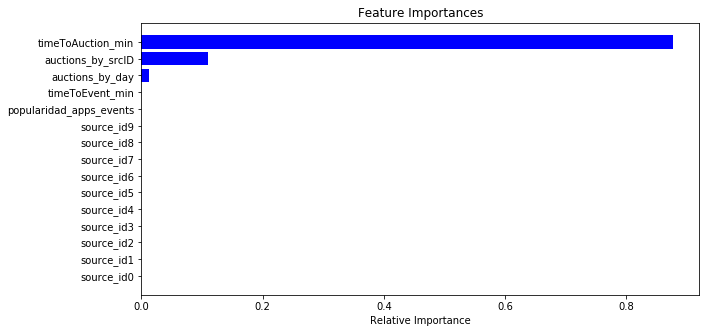

In [238]:
indices = np.argsort(importances)
plt.figure(figsize = (10,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [252]:
y = data14['predict_value']
X = data14.drop(['ref_hash', 'predict_value'], axis=1)

RFR = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
RFR.fit(X, y)  
RFR.feature_importances_

array([8.01123005e-05, 1.47372597e-05, 2.32321209e-05, 3.65015389e-06,
       5.97235189e-06, 0.00000000e+00, 1.21912699e-05, 0.00000000e+00,
       1.25571226e-05, 0.00000000e+00, 1.17782093e-05, 5.54403565e-06,
       7.24166753e-02, 1.65878419e-05, 9.01333280e-05, 9.27289875e-01,
       1.69539976e-05])

In [253]:
importances = RFR.feature_importances_
features = X.columns

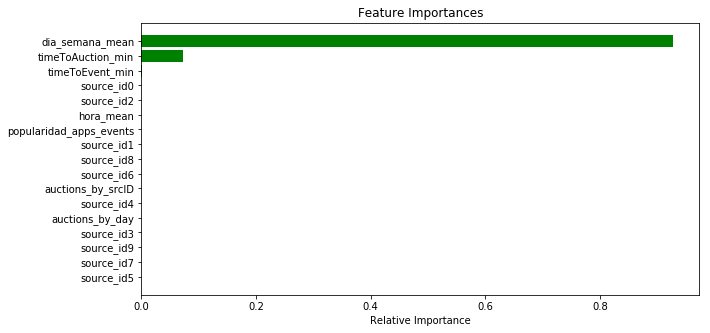

In [254]:
indices = np.argsort(importances)
plt.figure(figsize = (10,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Sc

In [244]:
y = new_data7['predict_time_install']
X = new_data7.drop(['ref_hash', 'predict_time_install'], axis=1)

RFR = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
RFR.fit(X, y)  
RFR.feature_importances_

array([9.79548044e-01, 1.45801441e-02, 3.52473709e-03, 5.35383116e-04,
       1.07963516e-03, 7.32056708e-04])

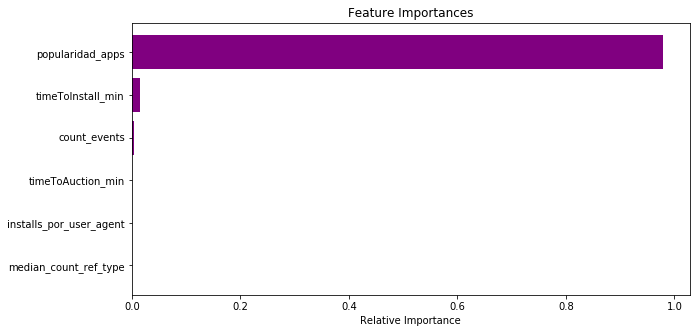

In [247]:
importances = RFR.feature_importances_
features = X.columns
indices = np.argsort(importances)
plt.figure(figsize = (10,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='purple', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [250]:
y = new_data14['predict_time_install']
X = new_data14.drop(['ref_hash', 'predict_time_install'], axis=1)

RFR = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
RFR.fit(X, y)  
RFR.feature_importances_

array([2.28526418e-01, 0.00000000e+00, 1.59041364e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.08576408e-01,
       2.53556125e-01, 3.09182007e-01])

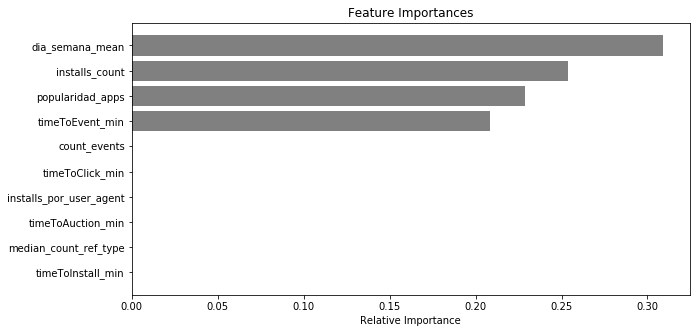

In [251]:
importances = RFR.feature_importances_
features = X.columns
indices = np.argsort(importances)
plt.figure(figsize = (10,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='grey', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Guardo los features de cada ventana

## Features sobre st

In [224]:
#Utilizo el set de features que contien los features más importantes
data13.head()

,ref_hash,predict_value,source_id0,source_id1,source_id2,source_id3,source_id4,source_id5,source_id6,source_id7,source_id8,source_id9,auctions_by_srcID,auctions_by_day,timeToAuction_min,popularidad_apps_events,timeToEvent_min,dia_semana_mean
0,1000169251625791246,76114.647428,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.213594,2.5,46581.029283,3.0,6976.388,2.857143
1,1000395625957344683,8034.974209,0.0,11.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,3.470511,7.0,2467.488253,0.0,259200.000,2.875000
2,1003027494996471685,12171.691046,102.0,3.0,0.0,23.0,2.0,0.0,36.0,0.0,2.0,0.0,32.358410,84.0,98571.691046,14.0,3666.737,3.220238
3,1006670001679961544,64857.606340,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316228,0.5,151257.606340,0.0,259200.000,3.000000
4,1007573308966476713,18726.239096,0.0,4.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.337494,3.0,32222.420264,0.0,259200.000,3.142857


In [240]:
data13.to_csv(path_or_buf = 'features_anteriores_St.csv', index = False)


In [ ]:
features = features.merge(target[['ref_hash']])
y_train = features['predict_value']
X_train = features.drop(['ref_hash', 'predict_value'], axis=1)

XGB = xgb.XGBRegressor( max_depth=3, learning_rate=0.1, n_estimators=100,
                       verbosity=1, silent=None, objective='reg:linear', n_jobs=1, gamma=0,
                       min_child_weight=1,  max_delta_step=0, reg_alpha=0, reg_lambda=1, 
                       scale_pos_weight=1, base_score=0.5, random_state=0, importance_type='gain')

scores = cross_val_score(XGB , X_train, y_train, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

In [ ]:
data_final = data7.merge(target[['ref_hash']], on = 'ref_hash')
data_final = data_final.drop(columns = ['ref_hash', 'predict_value'])

In [ ]:
XGB = xgb.XGBRegressor( max_depth=3, learning_rate=0.1, n_estimators=100,
                       verbosity=1, silent=None, objective='reg:linear', n_jobs=1, gamma=0,
                       min_child_weight=1,  max_delta_step=0, reg_alpha=0, reg_lambda=1, 
                       scale_pos_weight=1, base_score=0.5, random_state=0, importance_type='gain')
XGB.fit(X_train, y_train)
result = XGB.predict(data_final)

In [ ]:
target.drop(columns = 'obj', inplace = True)
target.count()

In [ ]:
len(result)

In [ ]:
submit = []
for l in result:
    submit.append(l)
target['obj'] = submit

In [ ]:
target['ref_hash'] = target['ref_hash'].transform(lambda x: str(x) + '_st')
target.head()

In [ ]:
target.to_csv(path_or_buf = "submit_st.csv", index = False)

## Creo las predicciones sc con todos los ids

In [255]:
new_data14.to_csv(path_or_buf = 'features_anteriores_Sc.csv', index = False)


In [ ]:
y_train = features_train['predict_time_install']
X_train = features_train.drop(['ref_hash', 'predict_time_install'], axis=1)

XGB = xgb.XGBRegressor()
XGB.fit(X_train, y_train)

scores = cross_val_score(XGB , X_train, y_train, scoring = "neg_mean_squared_error", cv=5)

# RMSE
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores.mean()

In [ ]:
X_train.head()

In [ ]:
feature_final = new_data7.drop(columns = ['ref_hash','predict_time_install'])
feature_final.head()

In [ ]:
XGB = xgb.XGBRegressor()
XGB.fit(X_train, y_train)
result2 = XGB.predict(feature_final)

In [ ]:
target.drop(columns = 'obj', inplace = True)
target.count()

In [ ]:
submit = []
for l in result:
    submit.append(l)
target['obj'] = submit

In [ ]:
target['ref_hash'] = target['ref_hash'].transform(lambda x: str(x) + '_sc')
target.head()

In [ ]:
target.to_csv(path_or_buf = "submit_sc.csv", index = False)

## Armo el submit final

In [ ]:
st = pd.read_csv('submit_st.csv')
st.head()

In [ ]:
sc = pd.read_csv('submit_sc.csv')
sc.head()

In [ ]:
submit_final = st.merge(sc, on = 'ref_hash', how = 'outer')
submit_final = submit_final.sort_values(by = 'ref_hash')

In [ ]:
submit_final.head()

In [ ]:
submit_final['obj_x'] = submit_final['obj_x'].fillna(0)
submit_final['obj_y'] = submit_final['obj_y'].fillna(0)
submit_final['obj'] = submit_final['obj_x'] + submit_final['obj_y']
submit_final = submit_final[['ref_hash', 'obj']]
submit_final.head()

In [ ]:
submit_final.to_csv(path_or_buf = 'submit_final.csv', index = False)

In [ ]:
submit_final.count()